In [1]:
! git clone https://github.com/credwood/rir_ml.git

Cloning into 'rir_ml'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 91 (delta 47), reused 51 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 721.83 KiB | 22.56 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
! pip install -r rir_ml/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 43.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.0-py3-none-any.whl.metadata (10.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00


In [3]:
import sys
sys.path.append('/content/rir_ml')


In [4]:
import logging
from datetime import datetime
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
from torch import optim
from tqdm import tqdm

from core.dataset_utils import RIRHDF5Dataset, denormalize
from core.models import CNN1D
from core.training_utils import WeightedMSELoss


In [6]:
# Mount Google Drive to access your data
from google.colab import drive
drive.mount('/content/drive')

# Now you can use your HDF5 files like this:
rir_path = '/content/drive/MyDrive/rir_data/rir_dataset.h5'
metrics_path = '/content/drive/MyDrive/rir_data/rir_metrics.h5'

Mounted at /content/drive


In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

# Full dataset
full_dataset = RIRHDF5Dataset(rir_path, metrics_path)

indices = list(range(len(full_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Get train targets
train_targets = np.stack([full_dataset[i][1].numpy() for i in train_idx])
target_mean = train_targets.mean(axis=0)
target_std = train_targets.std(axis=0)

train_set = RIRHDF5Dataset(
    rir_path, metrics_path,
    normalize_targets=True,
    target_mean=target_mean,
    target_std=target_std,
    subset_indices=train_idx
)

val_set = RIRHDF5Dataset(
    rir_path, metrics_path,
    normalize_targets=True,
    target_mean=target_mean,
    target_std=target_std,
    subset_indices=val_idx
)


In [8]:
# Set up log file path
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = "training_logs"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"train_{timestamp}.log")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger()

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from IPython.display import clear_output, display
from collections import defaultdict


def init_weights_kaiming(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)


def plot_metrics(history):
    """
    Plots training and validation loss, and real-world MAE curves for all metrics.
    Ensures integer epoch ticks.
    """
    epochs = list(range(1, len(history['train_loss']) + 1))

    # --- Plot Training and Validation Loss ---
    plt.figure(figsize=(8, 5))
    ax = sns.lineplot(x=epochs, y=history['train_loss'], label='Train Loss')
    sns.lineplot(x=epochs, y=history['val_loss'], label='Val Loss')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Real-World MAE (Seconds) ---
    plt.figure(figsize=(10, 5))
    ax = sns.lineplot(x=epochs, y=history['mae_rt60'], label='RT60 (s)')
    sns.lineplot(x=epochs, y=history['mae_edt'], label='EDT (s)')
    sns.lineplot(x=epochs, y=history['mae_d50'], label='D50')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Real-World MAE — Time-Based Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("MAE (seconds)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Real-World MAE (Decibels) ---
    plt.figure(figsize=(6, 5))
    ax = sns.lineplot(x=epochs, y=history['mae_c50'], label='C50 (dB)', color='orange')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Real-World MAE — C50")
    plt.xlabel("Epoch")
    plt.ylabel("MAE (dB)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def train_model(model, train_dataset, val_dataset, num_epochs=20, batch_size=64, lr=1e-4, device='cuda'):
    """
    Trains the model on normalized metrics, using AdamW and validation-based LR scheduler.
    """
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    metric_weights = torch.tensor([0.5, 3.0, 2.0, 0.5])
    criterion = WeightedMSELoss(metric_weights).to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    best_val_loss = float("inf")
    history = defaultdict(list)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for rirs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            rirs, targets = rirs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(rirs.unsqueeze(1))  # [B, 1, N]
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        mae_sum = torch.zeros(4, device=device)
        num_batches = 0
        with torch.no_grad():
            for rirs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                rirs, targets = rirs.to(device), targets.to(device)
                outputs = model(rirs.unsqueeze(1))
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                # Denormalize for metric reporting
                # Denormalize to linear space
                outputs_real = denormalize(outputs, val_dataset.target_mean, val_dataset.target_std)
                targets_real = denormalize(targets, val_dataset.target_mean, val_dataset.target_std)

                # Compute MAE in real-world scale
                mae_batch = torch.mean(torch.abs(outputs_real - targets_real), dim=0)

                mae_report = mae_batch.clone()
                mae_report[2] = 10 * torch.log10(mae_report[2].clamp(min=1e-12))

                mae_sum += mae_report
                num_batches += 1

        avg_val_loss = val_loss / num_batches
        avg_mae = (mae_sum / num_batches).cpu().numpy()

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_cnn_model.pt")
            logger.info(f"New best model saved at epoch {epoch+1} with val loss {avg_val_loss:.4f}")

        logger.info(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        logger.info(f"MAE — RT60: {avg_mae[0]:.4f}s | EDT: {avg_mae[1]:.4f}s | C50: {avg_mae[2]:.2f}dB | D50: {avg_mae[3]:.3f}")
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["mae_rt60"].append(avg_mae[0])
        history["mae_edt"].append(avg_mae[1])
        history["mae_c50"].append(avg_mae[2])
        history["mae_d50"].append(avg_mae[3])
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"Real-World MAE: RT60={avg_mae[0]:.4f}s, EDT={avg_mae[1]:.4f}s, C50={avg_mae[2]:.2f}dB, D50={avg_mae[3]:.3f}")


        #plot_metrics(history)

    return model


/content/rir_ml/core/training_utils.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("weights", torch.tensor(weights, dtype=torch.float32))
Epoch 1 Validation: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Epoch 1 | Train Loss: 1.5129 | Val Loss: 1.4562
Real-World MAE: RT60=0.0901s, EDT=15.6727s, C50=112.37dB, D50=0.110


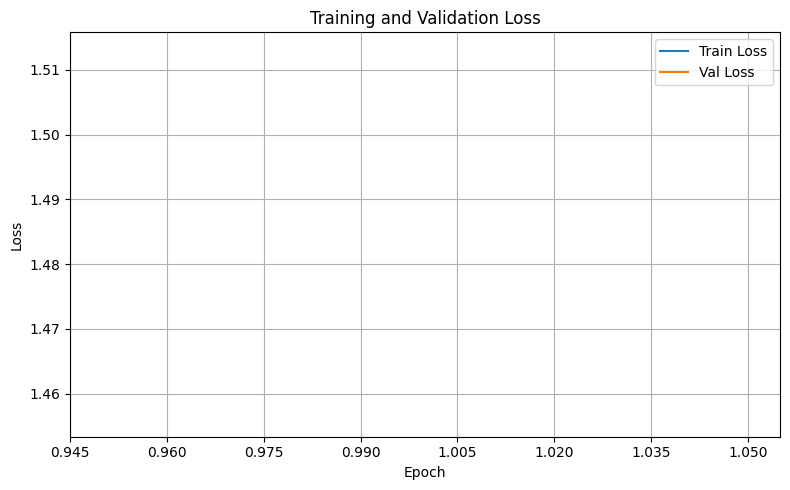

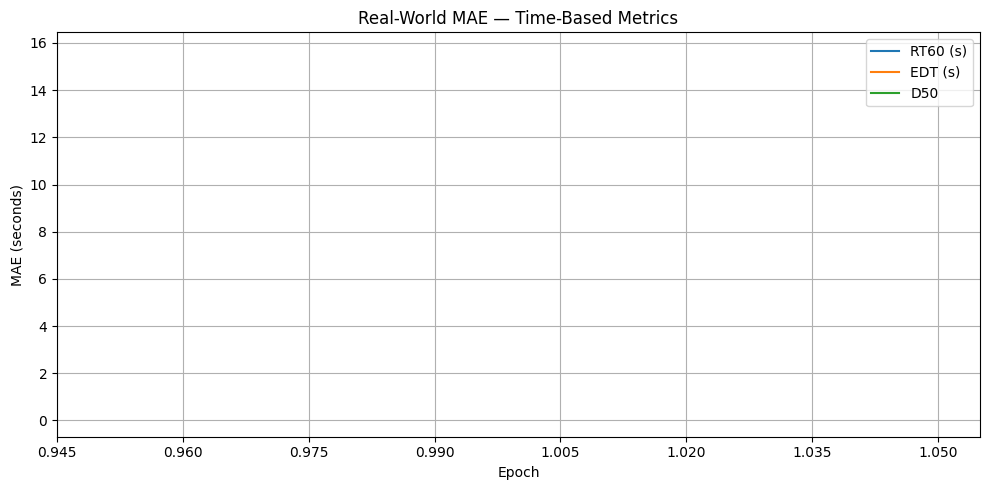

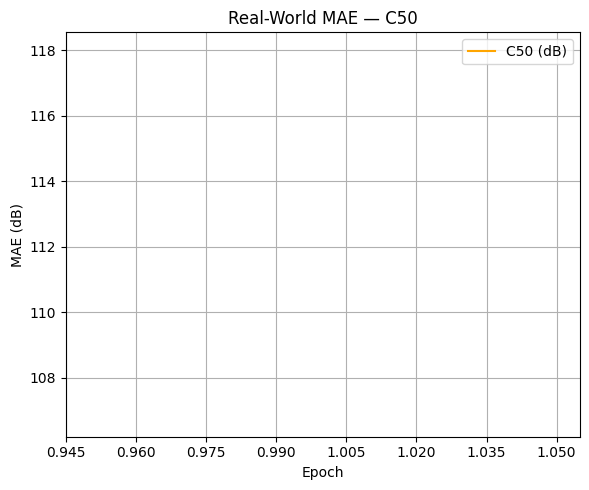

Epoch 2 Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch 2 | Train Loss: 1.4733 | Val Loss: 1.4272
Real-World MAE: RT60=0.0897s, EDT=14.5515s, C50=112.52dB, D50=0.108


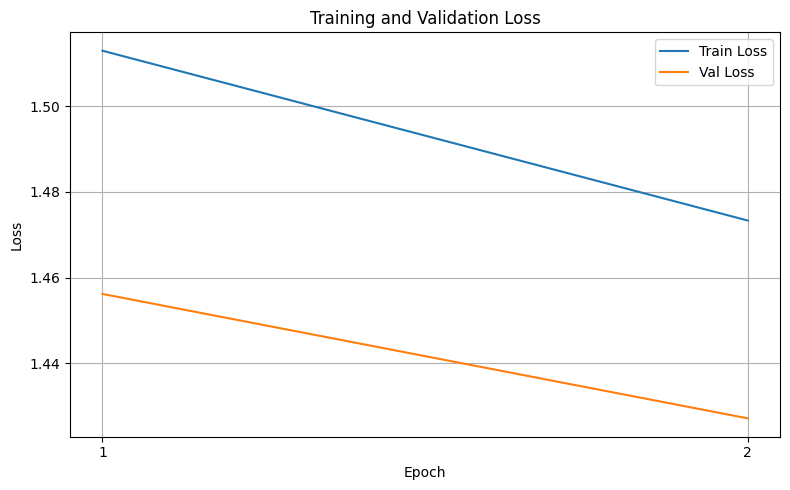

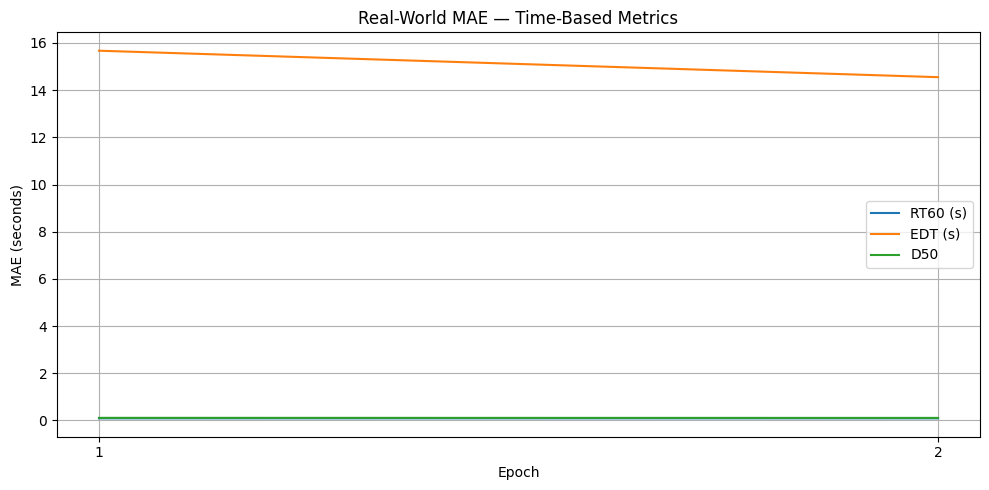

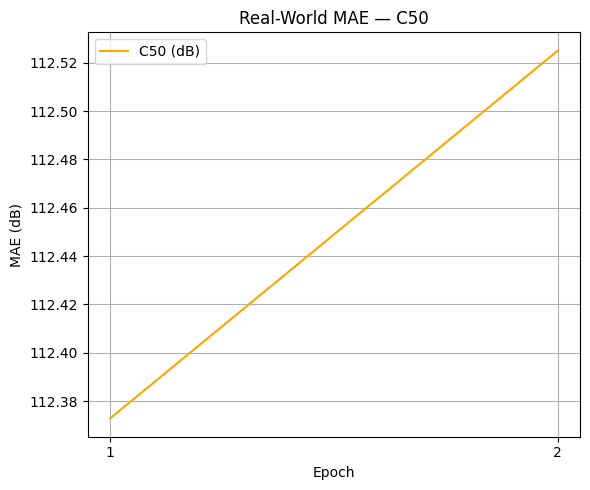

Epoch 3 Training:  38%|███▊      | 15/39 [00:41<01:06,  2.78s/it]


KeyboardInterrupt: 

In [10]:
model = CNN1D()
model.apply(init_weights_kaiming)
model = train_model(model, train_set, val_set, num_epochs=20, batch_size=1024, lr=1e-5, device='cuda')